# Checkpoint 3:
## Stacking

In [1]:
!pip install 'dtreeviz'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.7 MB/s eta 0:00:00


In [2]:
!wget https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_train.csv

--2023-10-11 19:50:01--  https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9788953 (9.3M) [text/plain]
Saving to: ‘hotels_train.csv’

hotels_train.csv    100%[===================>]   9.33M  --.-KB/s    in 0.1s    

2023-10-11 19:50:02 (68.4 MB/s) - ‘hotels_train.csv’ saved [9788953/9788953]



In [3]:
!wget https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_test.csv

--2023-10-11 19:50:02--  https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4432981 (4.2M) [text/plain]
Saving to: ‘hotels_test.csv’

hotels_test.csv     100%[===================>]   4.23M  --.-KB/s    in 0.05s   

2023-10-11 19:50:02 (77.6 MB/s) - ‘hotels_test.csv’ saved [4432981/4432981]



In [4]:
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

#modelos y métricas
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [5]:
df = pd.read_csv("hotels_train.csv")

df_filtrado = df.copy()

In [6]:
df.head(3)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,No Deposit,9.0,NaN,0,Transient,115.5,0,1,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,No Deposit,NaN,NaN,0,Transient,42.0,1,0,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2.0,...,No Deposit,9.0,NaN,0,Transient,229.0,0,2,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0


# Modificando el dataset

In [7]:
df_filtrado = df_filtrado.drop('id', axis=1)

In [9]:
df_filtrado.children = df_filtrado.children.replace(np.nan, 0)
df_filtrado.agent = df_filtrado.agent.replace(np.nan, -1)
df_filtrado.company = df_filtrado.company.replace(np.nan, -1)
df_filtrado['country'] = df_filtrado['country'].replace(np.nan, 'PRT')

In [11]:
df_filtrado = df_filtrado.replace({'adults': 0}, value=2)
df_filtrado = df_filtrado.replace({'children': 10}, value=0)
df_filtrado = df_filtrado.replace({'babies': 9}, value=0)
df_filtrado = df_filtrado.replace({'adr': -6.38}, value=df_filtrado['adr'].median())
df_filtrado = df_filtrado.replace({'adr': 0}, value=df_filtrado['adr'].median())

# Encoding y Separacion de Columnas

Usando una prroporción de 70 y 30 separo mi dataset en train y validation

In [22]:
ds_encodeado = pd.get_dummies(df_filtrado, columns=["hotel", "arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type", "customer_type"], drop_first=True)
ds_encodeado.head(3)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,49,2016,37,5,1,2,1,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,4,2015,44,31,0,1,2,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,25,2016,42,13,0,1,2,2.0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [23]:
ds_trabajo_x=ds_encodeado.drop(['is_canceled'], axis='columns', inplace=False)

ds_trabajo_y = ds_encodeado['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=20)

# Entrenamiento y predicción

In [27]:
from sklearn.ensemble import StackingClassifier

#Modelos Base
base_models = [('random_forest', RandomForestClassifier(n_estimators=93,
                                                        min_samples_split=4,
                                                        min_samples_leaf=1,
                                                        max_depth=38,
                                                        criterion='gini')),
               ('xgbost', xgb.XGBClassifier(subsample=0.9,
                              objective='binary:logistic',
                              n_estimators=958,
                              max_depth=33,
                              learning_rate=0.01,
                              reg_lambda=0.4,
                              gamma=1,
                              colsample_bytree=0.9,
                              alpha=0.2)),
               ('dtc', tree.DecisionTreeClassifier(min_samples_split=4,
                                             min_samples_leaf=3,
                                              max_depth=15,
                                              criterion='gini',
                                              ccp_alpha=0.00011111111111111112))]

#Meta Modelo
meta_model = xgb.XGBClassifier(subsample=0.9,
                              objective='binary:logistic',
                              n_estimators=958,
                              max_depth=33,
                              learning_rate=0.01,
                              reg_lambda=0.4,
                              gamma=1,
                              colsample_bytree=0.9,
                              alpha=0.2)

#Ensemble Stacking
stacking_model = StackingClassifier(estimators=base_models,
                                    final_estimator=meta_model,
                                    passthrough=True,
                                    cv=5,
                                    verbose=2)

stacking_model.fit(x_train.sort_index(axis=1),y_train)

StackingClassifier(cv=5,
                   estimators=[('random_forest',
                                RandomForestClassifier(max_depth=38,
                                                       min_samples_split=4,
                                                       n_estimators=93)),
                               ('xgbost',
                                XGBClassifier(alpha=0.2, base_score=None,
                                              booster=None, callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.9, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=Non...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.01,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=33, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=958, n_jobs=None,
                                                 num_parallel_tree=None, ...),
                   passthrough=True, verbose=2)

In [29]:
y_pred = stacking_model.predict(x_test.sort_index(axis=1))
#Valores Predichos
y_pred

array([1, 1, 1, ..., 1, 0, 0])

In [30]:
y_test.values

array([1, 1, 1, ..., 1, 1, 0])

In [31]:
ds_resultados=pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])
ds_resultados.head(10)

,test,pred
0,1,1
1,1,1
2,1,1
3,0,0
4,1,1
5,1,1
6,1,1
7,0,0
8,1,1
9,1,1


Text(50.722222222222214, 0.5, 'True')

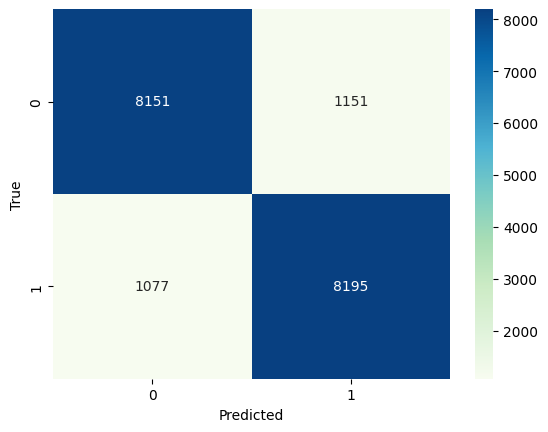

In [32]:
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [33]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8800473780553462
Recall: 0.8838438308886971
Precision: 0.8768457093943933
f1 score: 0.8803308626060802


In [34]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      9302
           1       0.88      0.88      0.88      9272

    accuracy                           0.88     18574
   macro avg       0.88      0.88      0.88     18574
weighted avg       0.88      0.88      0.88     18574



# Test prediction

## Modificando el Dataset

In [35]:
df_test = pd.read_csv("hotels_test.csv")

df_test_filtrado = df_test.copy()

In [36]:
df_test_filtrado['reservation_status_date']

0        2016-04-04
1        2016-01-22
2        2016-08-24
3        2016-11-05
4        2016-10-18
            ...    
26530    2017-04-26
26531    2016-09-06
26532    2016-08-04
26533    2017-03-07
26534    2016-03-27
Name: reservation_status_date, Length: 26535, dtype: object

In [37]:
df_test_ids = df_test['id']
df_test_filtrado = df_test_filtrado.drop('id', axis=1)
df_test_filtrado = df_test_filtrado.drop('reservation_status_date', axis=1)

In [38]:
df_test_filtrado['country'] = df_test_filtrado['country'].replace(np.nan, 'PRT')
df_test_filtrado.agent = df_test_filtrado.agent.replace(np.nan, -1)
df_test_filtrado.company = df_test_filtrado.company.replace(np.nan, -1)
df_filtrado.children = df_filtrado.children.replace(np.nan, 0)

Tratamos de eliminar los paises que solo aparecen en el set de test y no en el de train.

In [43]:
lista_paises_unicos_test = df_test_filtrado['country'].unique()
lista_paises_unicos = df_filtrado['country'].unique()
conjunto1 = set(lista_paises_unicos)
conjunto2 = set(lista_paises_unicos_test)


# Obtener los elementos que están en conjunto1 pero no en conjunto2
elementos_en_lista1_no_en_lista2 = list(conjunto2 - conjunto1)
print(elementos_en_lista1_no_en_lista2)

df_test_filtrado["country"] = df_test_filtrado["country"].replace(to_replace=elementos_en_lista1_no_en_lista2, value="PRT")

['ASM', 'DMA', 'SMR', 'DJI', 'KHM', 'TMP', 'MLI', 'UZB', 'SLV', 'ATF', 'NIC', 'BFA']


In [46]:
df_test_filtrado["adults"] = df_test_filtrado["adults"].replace(to_replace=0, value=2)
df_test_filtrado["adr"] = df_test_filtrado["adr"].replace(to_replace=0, value=df_filtrado['adr'].median())

In [51]:
df_test_encodeado = pd.get_dummies(df_test_filtrado, columns=["hotel", "arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type", "customer_type"], drop_first=True)


## Prediccion

In [52]:
lista = df_test_encodeado.columns
columnas_faltantes = []
for colum in ds_encodeado.columns:
  if(colum not in lista and colum != "is_canceled"):
    print(colum)
    columnas_faltantes.append(colum)

for colum_faltante in columnas_faltantes:
  df_test_encodeado[colum_faltante] = 0

country_ARM
country_AZE
country_BEN
country_CIV
country_COM
country_ETH
country_FJI
country_FRO
country_GTM
country_HND
country_KEN
country_KNA
country_MDG
country_MNE
country_MUS
country_MYT
country_NAM
country_PAN
country_PYF
country_SDN
country_SYC
country_SYR
country_TGO
country_UMI
country_VGB
country_ZMB
market_segment_Undefined
distribution_channel_Undefined
assigned_room_type_L


In [55]:
lista = ds_encodeado.columns
for colum in df_test_encodeado.columns:
  if(colum not in lista):
    print(colum)

In [58]:
test_pred_2 = stacking_model.predict(df_test_encodeado.sort_index(axis=1))
#Valores Predichos
test_pred_2

array([1, 1, 0, ..., 1, 1, 0])

In [62]:
# Crear un DataFrame con las columnas "id" e "is_canceled"
data = {'id': df_test_ids, 'is_canceled': test_pred_2}
df_final_finalisimo = pd.DataFrame(data)

In [63]:
df_final_finalisimo.isna().any()

id             False
is_canceled    False
dtype: bool

In [64]:
df_final_finalisimo.head(10)

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
5,c142b61c-3035-46e7-8cf7-3720a29d0d61,1
6,8c4171ad-9837-4468-ac8e-8cb3d5a41b55,0
7,3ce60033-4529-4314-be77-db4a7737f326,0
8,7ab807a4-5e90-4205-b66e-0188696cc34b,1
9,a0ab0509-c8b0-4a2c-9f27-21f26e186520,0


In [65]:
df_final_finalisimo.to_csv('submission.csv', index=False)
